In [1]:
## import dependencies
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import datasets, plotting

from utils import load_config, load_surf, butterworth_highpass, zscore, load_mp3, get_envelope, lanczosinterp2D

cfg = load_config()
DATADIR = cfg['DATA_DIR']
STIMDIR = cfg['STIM_DIR']
FIGDIR = cfg['FIG_DIR']
STORIES = cfg['STORIES']

subject = 'sub-004'
# story = 'swimming'
STORIES = ['treasureisland']

tr = 1.5

# fsaverage dataset and labels
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage6')

# left hemisphere
surf_labels, ctab, surf_names = nib.freesurfer.read_annot('/Users/gio/Downloads/lh.Schaefer2018_200Parcels_17Networks_order.annot')
surf_labels = surf_labels.astype(int)
surf_names = [name.decode('utf-8') for name in surf_names]

## prepare x and y data for regression
# load fsaverage data
ydata_list = []
zEnv_list = []

for story in STORIES:
    surfdata = load_surf(DATADIR, subject, story)
    if surfdata is None:
        continue

    # filtering
    surf_cleaned = butterworth_highpass(surfdata, 1.5, 0.01)

    # zscore
    surf_zscored = zscore(surf_cleaned, axis=1)

    # trim the first 8 trs to align with stimulus onset
    surf_trimmed = surf_zscored[:, 8:]

    ydata_list.append(surf_trimmed)

    # save stimulus

    # auditory stimuli
    audio, sr = load_mp3(STIMDIR, story)
    audio_envelope = get_envelope(audio)

    n_trs= surf_trimmed.shape[1]

    # average envelope every 0.1 seconds
    window = 0.1
    audio_envelope_avg = np.mean(audio_envelope[:len(audio_envelope) // int(sr * window) * int(sr * window)].reshape(-1, int(sr * window)), axis=1).reshape(-1, 1)

    dsEnv = lanczosinterp2D(audio_envelope_avg, np.arange(audio_envelope_avg.shape[0]) * window, np.arange(n_trs) * tr)

    zEnv_list.append(zscore(dsEnv))

# concatenate data
ydata = np.concatenate(ydata_list, axis=1)
ydata = ydata.T
zEnv = np.concatenate(zEnv_list, axis=0)
print(ydata.shape)
print(zEnv.shape)

(567, 40962)
(567, 1)


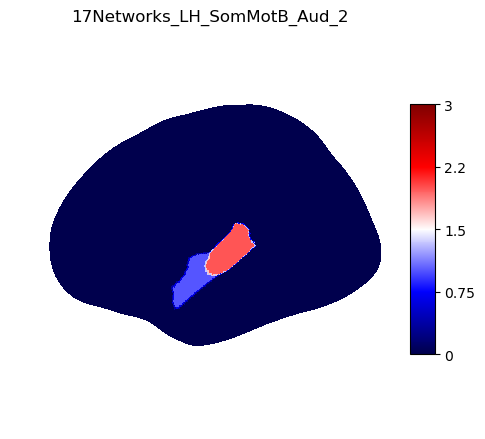

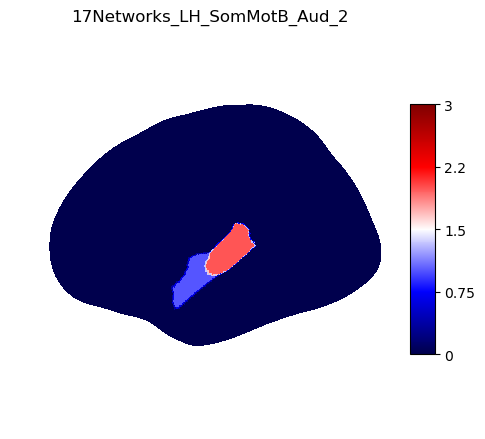

In [9]:
auditory_rois = ['17Networks_LH_SomMotB_Aud_1', '17Networks_LH_SomMotB_Aud_2']
mask = np.zeros_like(surf_labels)

for iroi, roi in enumerate(auditory_rois):
    roi_idx = surf_names.index(roi)

    mask[surf_labels == roi_idx] = iroi + 1

# plot the mask
plotting.plot_surf_stat_map(fsaverage.infl_left, mask, hemi='left', view='lateral', bg_map=fsaverage.sulc_left, colorbar=True, title=roi, cmap='seismic', vmax=3, vmin=0)